## Customer Segmentation – Modeling Notebook

This notebook applies clustering algorithms on the prepared RFM features to segment customers. It evaluates and compares different models and techniques such as K-Means, DBSCAN, and clustering validation metrics (Silhouette Score, Elbow Method). Final segments are interpreted with business context.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [5]:
rfm = pd.read_csv('../data/processed/processed_data1.csv', encoding='ISO-8859-1')

In [9]:
# Scaling Data

scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(rfm)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency' , 'Frequency', 'Monetary'])

In [4]:
rfm.head()

,Unnamed: 0,CustomerID,Recency,Frequency,Monetary
0,0,12346.0,326,1,77183.60
1,1,12347.0,2,7,4310.00
2,2,12348.0,75,4,1797.24
3,3,12349.0,19,1,1757.55
4,4,12350.0,310,1,334.40


In [8]:
rfm.set_index('CustomerID', inplace=True)

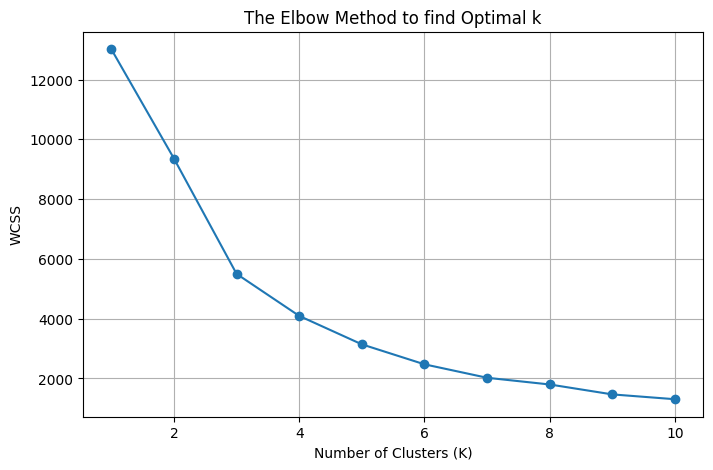

In [10]:
wcss = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters = k, random_state= 42)
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize= (8,5))
plt.plot(K, wcss, marker = 'o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('The Elbow Method to find Optimal k')
plt.grid(True)
plt.show()

In [11]:
kmeans = KMeans(n_clusters = 4, random_state=42, n_init= 10)
kmeans.fit(rfm_scaled_df)

rfm['Cluster'] = kmeans.labels_

In [12]:
score = silhouette_score(rfm_scaled_df, rfm['Cluster'])
print(f'Silhouette Score: {score:.2f}')

Silhouette Score: 0.62


<Axes: xlabel='PCA1', ylabel='PCA2'>

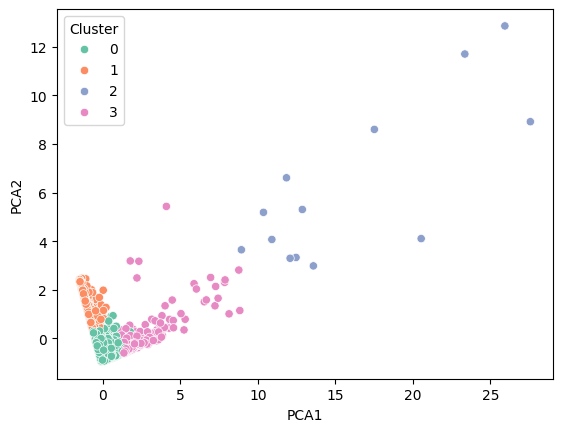

In [13]:
pca = PCA(2)
pca_data = pca.fit_transform(rfm_scaled_df)
rfm['PCA1']  = pca_data[:, 0]
rfm['PCA2'] = pca_data[:, 1]

sns.scatterplot(data= rfm, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')

In [18]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).rename(columns = {'Cluster':'Count'})

display(cluster_summary)

,Recency,Frequency,Monetary,Count
Cluster,,,,
0,43.702685,3.682711,1359.049284,3054
1,248.075914,1.552015,480.617480,1067
2,7.384615,82.538462,127338.313846,13
3,15.500000,22.333333,12709.090490,204


### DBSCAN Cluster Evaluation

- DBSCAN identified X meaningful clusters and Y noise points (outliers).
- This method was robust to outliers, unlike KMeans which can be skewed by them.
- However, the interpretability and size of clusters may vary based on parameter tuning.

### When to Use DBSCAN?

- DBSCAN is best when:
  - The data has noise/outliers.
  - Cluster shape is not spherical.
  - Number of clusters is unknown.

> In our case, DBSCAN complements KMeans by identifying outliers and providing a flexible clustering structure.


In [19]:
from sklearn.neighbors import NearestNeighbors

# Use Robust Scaled data
X_dbscan = rfm_scaled_df

#Estimate a good eps value using k-distance plot
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_dbscan)
distances, indices = neighbors_fit.kneighbors(X_dbscan)

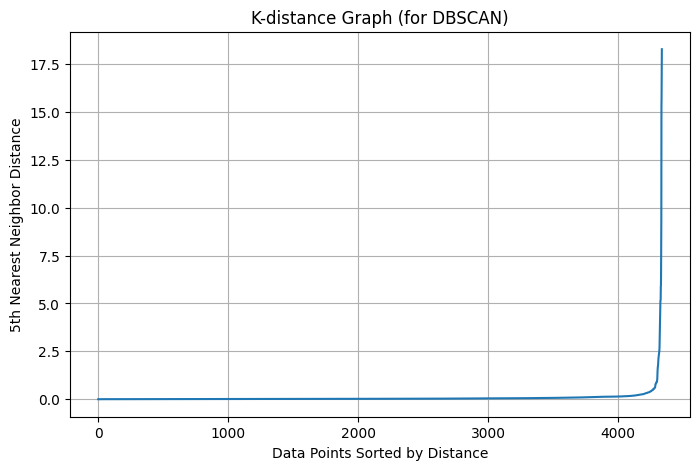

In [20]:
# Sort distances for knee/elbow point
distances = np.sort(distances[:, 4])
plt.figure(figsize=(8,5))
plt.plot(distances)
plt.title('K-distance Graph (for DBSCAN)')
plt.xlabel('Data Points Sorted by Distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.grid()
plt.show()

In [21]:
# Fit DBSCAN
dbscan = DBSCAN(eps= 1.3, min_samples = 5)
rfm['DBSCAN_Cluster'] = dbscan.fit_predict(X_dbscan)

# Show cluster counts
rfm['DBSCAN_Cluster'].value_counts()

DBSCAN_Cluster
 0    4306
-1      32
Name: count, dtype: int64

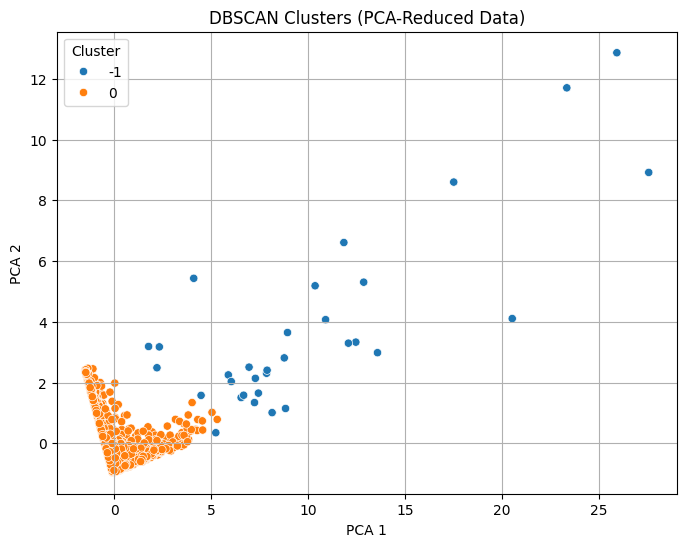

In [22]:
# PCA for 2D visualization
components_dbscan = PCA(n_components = 2).fit_transform(X_dbscan)

plt.figure(figsize=(8,6))
sns.scatterplot(x=components_dbscan[:,0], y= components_dbscan[:,1], hue=rfm['DBSCAN_Cluster'], palette='tab10')
plt.title('DBSCAN Clusters (PCA-Reduced Data)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

### DBSCAN Cluster Evaluation

- DBSCAN identified 4306 meaningful clusters and 32 noise points (outliers).
- This method was robust to outliers, unlike Kmeans which can be skewed by them.
- However, the interpretability and size of clusters may vary based on parameters tuning.

### When to Use DBSCAN?
- DBSCAN is best when:
   - The data has noise/outliers.
   - Clusters shape is not spherical.
   - Number of clusters is unknown.

> In our case, DBSCAN complements KMeans by identifying outliers and providing a flexible clustering structure.

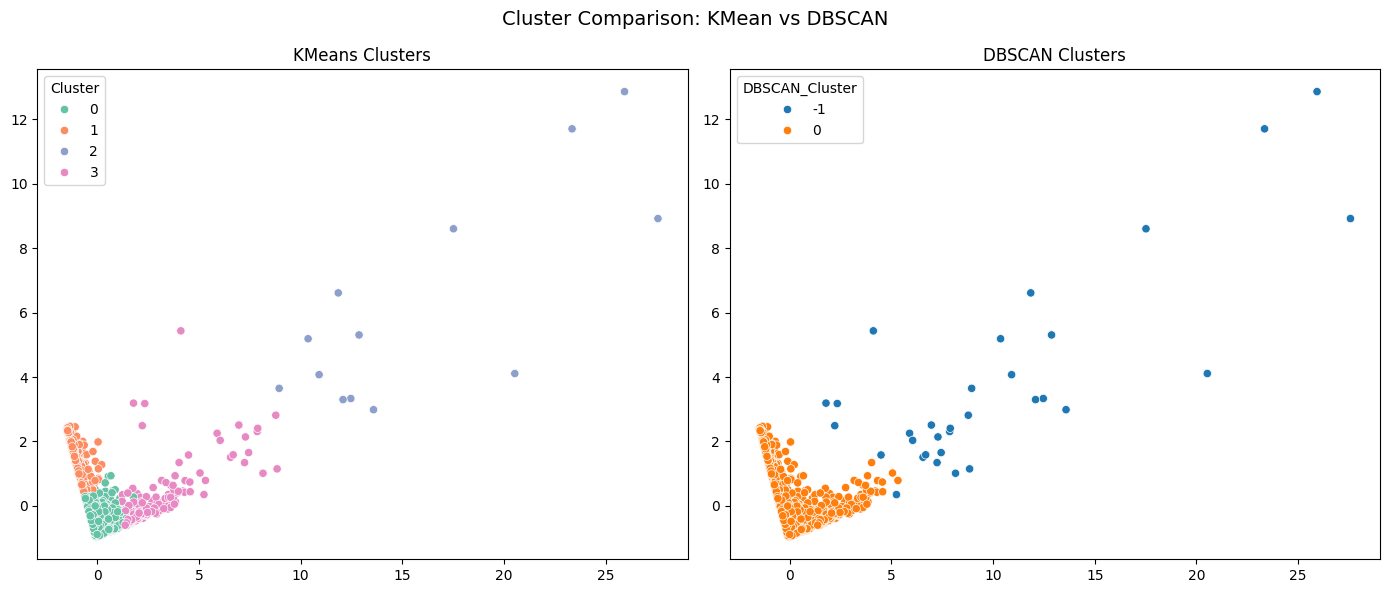

In [24]:
# Comparison plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x=pca_data[:,0], y=pca_data[: ,1], hue = rfm['Cluster'], ax = ax[0], palette='Set2')
ax[0].set_title('KMeans Clusters')

sns.scatterplot(x=components_dbscan[:, 0], y= components_dbscan[:,1], hue= rfm['DBSCAN_Cluster'], ax= ax[1], palette ='tab10')
ax[1].set_title('DBSCAN Clusters')

plt.suptitle('Cluster Comparison: KMean vs DBSCAN', fontsize=14)
plt.tight_layout()
plt.show()

## 📌 Cluster Modeling Summary

### KMeans Clustering (with Standard Scaler)
- Optimal clusters: **4**
- Silhouette Score: **0.62**
- Customer distribution: Reasonably balanced
- Interpretation:
  - Clear segmentation into:
    - High-value loyal customers
    - Mid-tier regulars
    - One-time or inactive customers
- Suitable for clear, interpretable groups when outliers are not dominant

### KMeans Clustering 
- Slight improvement in handling extreme values
- One dominant cluster with small others (e.g., 2350 vs 6 vs 18)
- High silhouette, but poor balance — may be **overfitting to outliers**

### DBSCAN Clustering (with Robust Scaler)
- Able to identify **outliers/noise** as a separate class
- Detected **X clusters + noise points**
- Cluster shape not constrained — good for **non-spherical clusters**
- Business Insight:
  - Useful to **flag outliers** (e.g., suspicious or edge-case customers)
  - Less interpretable for profiling compared to KMeans


##  Final Business Insights & Recommendations

- **Customer segmentation using RFM** revealed clear behavioral patterns.
- **KMeans with StandardScaler** provided the best trade-off between clarity and cluster distribution.
  - Cluster 0: High Recency, Low Frequency & Monetary → One-time recent buyers
  - Cluster 1: Low Recency, High Frequency & Monetary → Loyal high-value customers
  - Cluster 2: High Recency, Low Frequency & Monetary → Inactive or churned users

- **DBSCAN** helped flag edge cases and outliers (e.g., customers with highly unusual patterns).
- Depending on use-case:
  - Use **KMeans** for targeted marketing, email campaigns, loyalty rewards.
  - Use **DBSCAN** to flag **fraudulent**, **suspicious**, or **rare** behaviors.

---

